Visualizing our `f_b` scaling relation.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib notebook

from collections import defaultdict
from contextlib import contextmanager

import jax.numpy as jnp
from jax.config import config
config.update('jax_disable_jit', True)

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.special import beta, betainc as reg_betainc

from pydd.binary import *


@contextmanager
def autoscale_off(ax=None):
    ax = ax or plt.gca()
    lims = [ax.get_xlim(), ax.get_ylim()]
#     ax.autoscale(False)
    yield
#     ax.autoscale(True)
    ax.set_xlim(*lims[0])
    ax.set_ylim(*lims[1])

In [2]:
run_dir = "/nfs/scratch/kavanagh-runs/"


class RunFit(NamedTuple):
    """
    Container for f_b fit results
    """
    m_1: float  # MSUN
    m_2: float  # MSUN
    rho_s: float  # MSUN / PC**3
    rho6T: float  # 1e16 * MSUN / PC**3
    gamma_s: float
    f_b: float  # Hz
    id_str: str


results = dict(jnp.load("fb_fits.npz"))
vals = jnp.stack(list(results.values()), axis=-1)
fits = []
for v in vals:
    fits.append(RunFit(*v, ""))

In [3]:
def betainc(a, b, x):
    return beta(a, b) * reg_betainc(a, b, x)


def get_f_b_ana(m_1, m_2, gamma_s):
    h = betainc(gamma_s - 1/2, 3/2, 1.) - betainc(gamma_s - 1/2, 3/2, 1/2)
    g = (2**(3-gamma_s) + gamma_s - 4) / (
        (3 - gamma_s) * (2 - gamma_s) * h
    )
    return m_2**(3/5) / m_1**(8/5) * (jnp.log(1 + m_1 / m_2) / g)**(3/5)

In [4]:
# Split into calibration and test runs
results_val = defaultdict(lambda: [])
results_cal = defaultdict(lambda: [])
m_1_cal = jnp.array([1e3, 3e3, 1e4])
m_2_cal = jnp.array([1., 3., 10.])
gamma_s_cal = jnp.array([2.25, 2.3333, 2.5])

for val in vals:
    if val[0] in m_1_cal and val[1] in m_2_cal and val[4] in gamma_s_cal:
        for i, k in enumerate(results.keys()):
            results_cal[k].append(val[i])
    else:
        for i, k in enumerate(results.keys()):
            results_val[k].append(val[i])

results_cal = {k: jnp.array(v) for k, v in results_cal.items()}
results_val = {k: jnp.array(v) for k, v in results_val.items()}

# Positions for calibration runs
x_coords_cal = np.zeros((len(results_cal["m_1"]),))
for m_1 in m_1_cal:
    for i, m_2 in enumerate(m_2_cal):
        for j, gamma_s in enumerate(gamma_s_cal):
            idxs = jnp.where(
                (results_cal["m_1"] == m_1)
                & (results_cal["m_2"] == m_2)
                & (results_cal["gamma_s"] == gamma_s)
            )
            x_coords_cal[idxs] = i + (j - 1) / 4

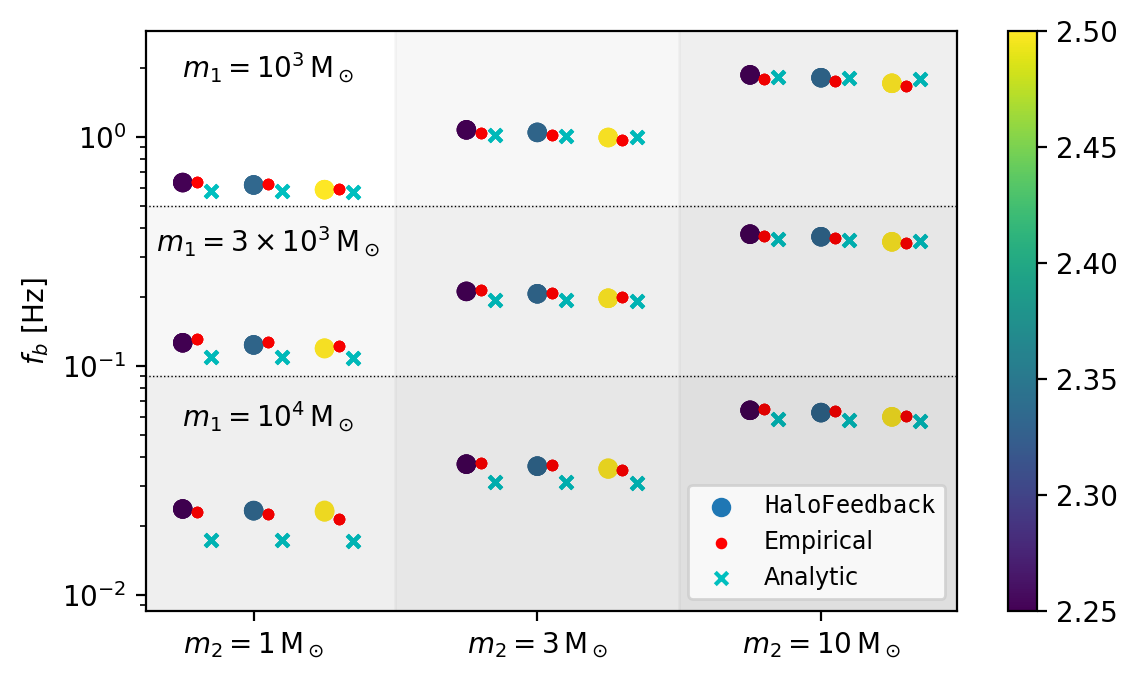

In [46]:
fig, axes = plt.subplots(1, 1, figsize=(6, 3.5), dpi=200)

ax = axes
# Must format before autoscale_off
ax.set_yscale("log")
ax.set_ylabel(r"$f_b$ [Hz]")
ax.set_ylim(8.5e-3, 2.9)
ax.set_xticks(jnp.arange(len(m_2_cal)))
ax.set_xticklabels([r"$m_2 = %g\, \mathrm{M}_\odot$" % m_2 for m_2 in m_2_cal])
# ax.set_title("Calibration")

sc = ax.scatter(
    x_coords_cal,
    results_cal["f_b"],
    c=results_cal["gamma_s"],
    vmin=2.25,
    vmax=2.5,
    label=r"$\mathtt{HaloFeedback}$"
)
plt.colorbar(sc, ax=ax)

ax.scatter(
    x_coords_cal + 0.05,
    get_f_b(results_cal["m_1"] * MSUN, results_cal["m_2"] * MSUN, results_cal["gamma_s"]),
    c="r",
    s=10,
    vmin=2.25,
    vmax=2.5,
    label="Empirical"
)
ax.scatter(
    x_coords_cal + 0.1,
    get_f_b_ana(
        results_cal["m_1"] * MSUN, results_cal["m_2"] * MSUN, results_cal["gamma_s"]
    ) * 3.5e34,
    c="c",
    marker="x",
    s=20,
    vmin=2.25,
    vmax=2.5,
    label="Analytic"
)
ax.legend(loc="lower right", fontsize=8.5)

with autoscale_off(ax):
    ax.fill_between([-0.5, 2.5], 0, 0.5, color="k", alpha=0.03)
    ax.fill_between([-0.5, 2.5], 0, 0.09, color="k", alpha=0.03)
    ax.plot([-0.5, 2.5], 2 * [0.5], ":k", linewidth=0.5)
    ax.plot([-0.5, 2.5], 2 * [0.09], ":k", linewidth=0.5)
    ax.fill_betweenx([0, 5], 0.5, 2.5, color="k", alpha=0.03)
    ax.fill_betweenx([0, 5], 1.5, 2.5, color="k", alpha=0.03)

ax.text(0.05, 6e-2, r"$m_1 = 10^4\, \mathrm{M}_\odot$", ha="center", va="center")
ax.text(0.05, 3.5e-1, r"$m_1 = 3 \times 10^3\, \mathrm{M}_\odot$", ha="center", va="center")
ax.text(0.05, 2e0, r"$m_1 = 10^3\, \mathrm{M}_\odot$", ha="center", va="center")

fig.tight_layout()
fig.savefig("figures/f_b-scaling.pdf")

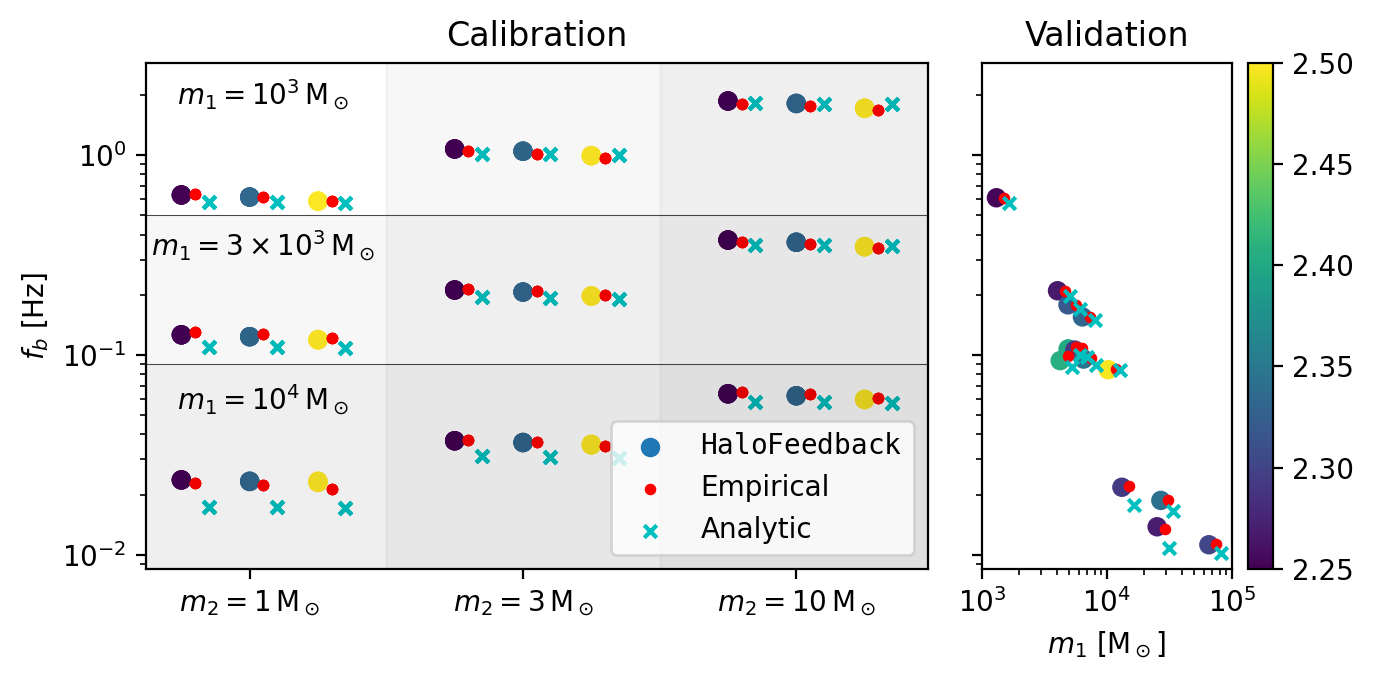

In [35]:
fig, axes = plt.subplots(
    1, 2, figsize=(7, 3.5), dpi=200, sharey=True, gridspec_kw={'width_ratios': [2.5, 1]}
)

ax = axes[0]
# Must format before autoscale_off
ax.set_yscale("log")
ax.set_ylabel(r"$f_b$ [Hz]")
ax.set_ylim(8.5e-3, 2.9)
ax.set_xticks(jnp.arange(len(m_2_cal)))
ax.set_xticklabels([r"$m_2 = %g\, \mathrm{M}_\odot$" % m_2 for m_2 in m_2_cal])
ax.set_title("Calibration")

ax.scatter(
    x_coords_cal,
    results_cal["f_b"],
    c=results_cal["gamma_s"],
    vmin=2.25,
    vmax=2.5,
    label=r"$\mathtt{HaloFeedback}$"
)
ax.scatter(
    x_coords_cal + 0.05,
    get_f_b(results_cal["m_1"] * MSUN, results_cal["m_2"] * MSUN, results_cal["gamma_s"]),
    c="r",
    s=10,
    vmin=2.25,
    vmax=2.5,
    label="Empirical"
)
ax.scatter(
    x_coords_cal + 0.1,
    get_f_b_ana(
        results_cal["m_1"] * MSUN, results_cal["m_2"] * MSUN, results_cal["gamma_s"]
    ) * 3.5e34,
    c="c",
    marker="x",
    s=20,
    vmin=2.25,
    vmax=2.5,
    label="Analytic"
)
ax.legend(loc="lower right")

with autoscale_off(ax):
    ax.fill_between([-0.5, 2.5], 0, 0.5, color="k", alpha=0.03)
    ax.fill_between([-0.5, 2.5], 0, 0.09, color="k", alpha=0.03)
    ax.plot([-0.5, 2.5], 2 * [0.5], color="k", linewidth=0.25)
    ax.plot([-0.5, 2.5], 2 * [0.09], color="k", linewidth=0.25)
    ax.fill_betweenx([0, 5], 0.5, 2.5, color="k", alpha=0.03)
    ax.fill_betweenx([0, 5], 1.5, 2.5, color="k", alpha=0.03)

ax.text(0.05, 6e-2, r"$m_1 = 10^4\, \mathrm{M}_\odot$", ha="center", va="center")
ax.text(0.05, 3.5e-1, r"$m_1 = 3 \times 10^3\, \mathrm{M}_\odot$", ha="center", va="center")
ax.text(0.05, 2e0, r"$m_1 = 10^3\, \mathrm{M}_\odot$", ha="center", va="center")

ax = axes[1]
ax.set_title("Validation")
ax.set_xscale("log")
ax.set_xlabel(r"$m_1$ [M$_\odot$]")
ax.set_xlim(1e3, 1e5)

# x_coords_val = np.random.rand(len(results_val["m_2"]))
x_coords_val = results_val["m_1"]
sc = ax.scatter(
    x_coords_val,
    results_val["f_b"],
    c=results_val["gamma_s"],
    vmin=2.25,
    vmax=2.5
)
plt.colorbar(sc, ax=ax)
ax.scatter(
    x_coords_val * 1.15,
    get_f_b(results_val["m_1"] * MSUN, results_val["m_2"] * MSUN, results_val["gamma_s"]),
    c="r",
    s=10,
    vmin=2.25,
    vmax=2.5,
)
ax.scatter(
    x_coords_val * 1.25,
    get_f_b_ana(
        results_val["m_1"] * MSUN, results_val["m_2"] * MSUN, results_val["gamma_s"]
    ) * 3.5e34,
    c="c",
    marker="x",
    s=20,
    vmin=2.25,
    vmax=2.5,
)

fig.tight_layout()
fig.savefig("figures/f_b-scaling.pdf")

## Other layouts

<IPython.core.display.Javascript object>


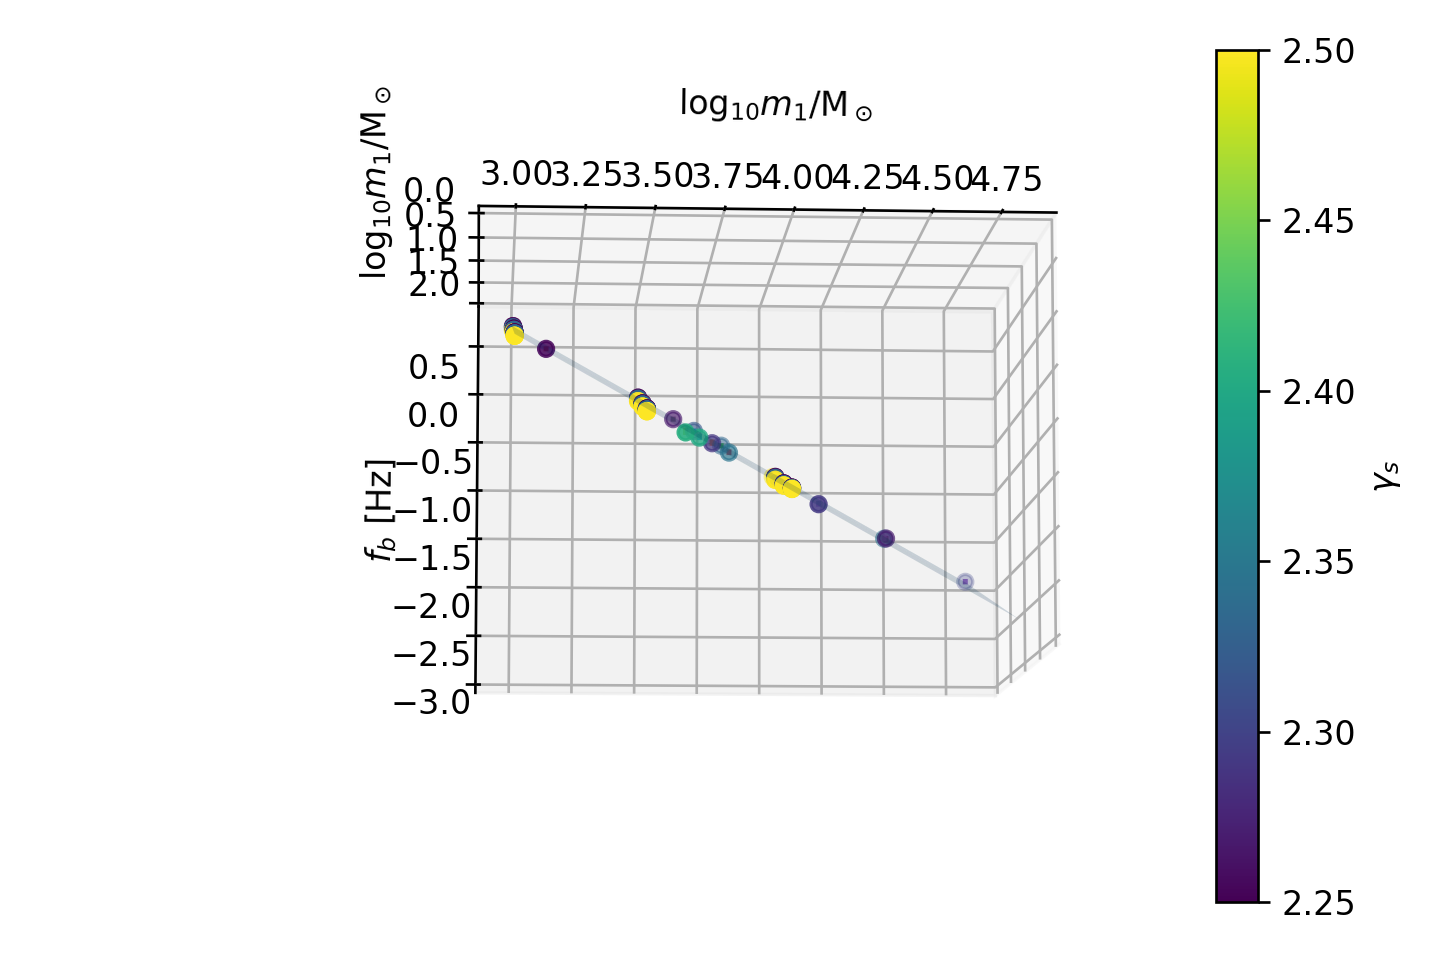

In [113]:
fig = plt.figure(dpi=120)
ax = plt.axes(projection='3d')

sc = ax.scatter3D(
    jnp.log10(results["m_1"]),
    jnp.log10(results["m_2"]),
    jnp.log10(results["f_b"]),
    c=results["gamma_s"],
    s=20
)
plt.colorbar(sc, ax=ax, label=r"$\gamma_s$", fraction=0.046, pad=0.04)

m_1s = jnp.geomspace(results["m_1"].min(), results["m_1"].max())
m_2s = jnp.geomspace(results["m_2"].min(), results["m_2"].max())
m_1_mg, m_2_mg = jnp.meshgrid(m_1s, m_2s)
ax.plot_surface(
    jnp.log10(m_1_mg),
    jnp.log10(m_2_mg),
    jnp.log10(get_f_b(m_1_mg * MSUN, m_2_mg * MSUN, 2.375)),
    alpha=0.2
)

for fit in fits:
    f_b = get_f_b(fit.m_1 * MSUN, fit.m_2 * MSUN, fit.gamma_s)
    ax.plot3D(
        2 * [jnp.log10(fit.m_1)],
        2 * [jnp.log10(fit.m_2)],
        [jnp.log10(f_b), jnp.log10(fit.f_b)],
    )

ax.set_xlabel(r"$\log_{10} m_1 / \mathrm{M}_\odot$")
ax.set_ylabel(r"$\log_{10} m_1 / \mathrm{M}_\odot$")
ax.set_zlabel(r"$f_b$ [Hz]")
fig.tight_layout()

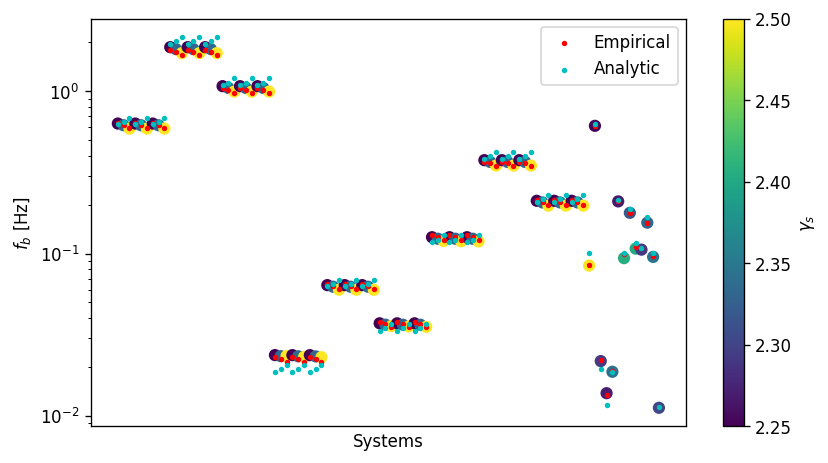

In [89]:
plt.figure(figsize=(8, 4.5), dpi=120)

plt.scatter(jnp.arange(len(fits)), results["f_b"], c=results["gamma_s"], s=40)
plt.colorbar(label=r"$\gamma_s$")
plt.scatter(
    jnp.arange(len(fits)),
    get_f_b(results["m_1"] * MSUN, results["m_2"] * MSUN, results["gamma_s"]),
    c="r",
    s=5,
    label="Empirical"
)
plt.scatter(
    jnp.arange(len(fits)),
    get_f_b_ana(results["m_1"] * MSUN, results["m_2"] * MSUN, results["gamma_s"]) * 1.9e34,
    c="c",
    s=5,
    label="Analytic"
)

plt.yscale("log")
plt.gca().xaxis.set_ticklabels([])
plt.gca().xaxis.set_ticks([])
plt.xlabel("Systems")
plt.ylabel(r"$f_b$ [Hz]")
plt.legend()

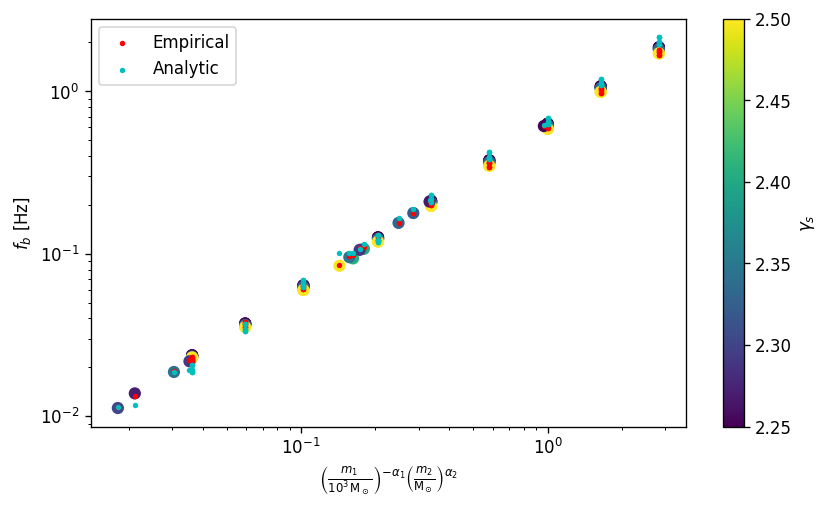

In [118]:
plt.figure(figsize=(8, 4.5), dpi=120)

m_ratio = (results["m_1"] / 1e3)**(-1.4412) * results["m_2"]**0.4511
plt.scatter(m_ratio, results["f_b"], c=results["gamma_s"], s=40)
plt.colorbar(label=r"$\gamma_s$")
plt.scatter(
    m_ratio,
    get_f_b(results["m_1"] * MSUN, results["m_2"] * MSUN, results["gamma_s"]),
    c="r",
    s=5,
    label="Empirical"
)
plt.scatter(
    m_ratio,
    get_f_b_ana(results["m_1"] * MSUN, results["m_2"] * MSUN, results["gamma_s"]) * 1.9e34,
    c="c",
    s=5,
    label="Analytic"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel(
    r"$\left( \frac{m_1}{10^3\, \mathrm{M}_\odot} \right)^{-\alpha_1}"
    r"\left( \frac{m_2}{\mathrm{M}_\odot} \right)^{\alpha_2}$"
)
plt.ylabel(r"$f_b$ [Hz]")
plt.legend()

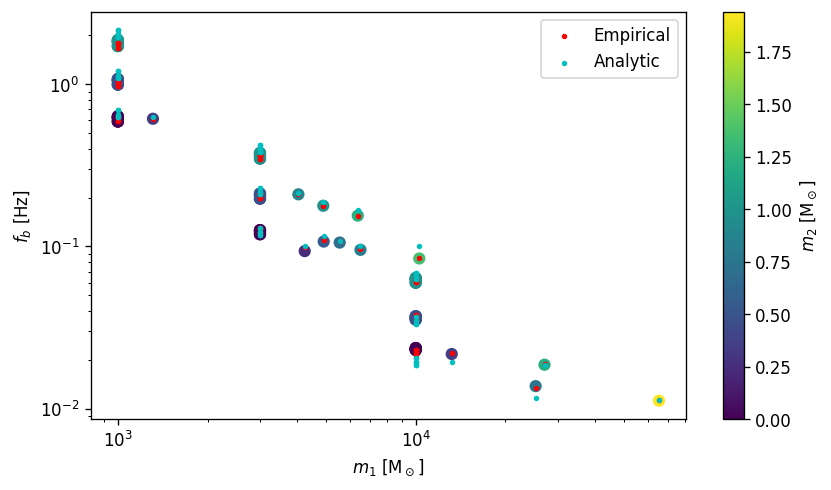

In [92]:
plt.figure(figsize=(8, 4.5), dpi=120)

plt.scatter(results["m_1"], results["f_b"], c=jnp.log10(results["m_2"]), s=40)
plt.colorbar(label=r"$m_2$ [M$_\odot$]")
plt.scatter(
    results["m_1"],
    get_f_b(results["m_1"] * MSUN, results["m_2"] * MSUN, results["gamma_s"]),
    c="r",
    s=5,
    label="Empirical"
)
plt.scatter(
    results["m_1"],
    get_f_b_ana(results["m_1"] * MSUN, results["m_2"] * MSUN, results["gamma_s"]) * 1.9e34,
    c="c",
    s=5,
    label="Analytic"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$f_b$ [Hz]")
plt.legend()

Text(0, 0.5, '$f_b / f_{b,\\mathrm{est}}$ [Hz]')

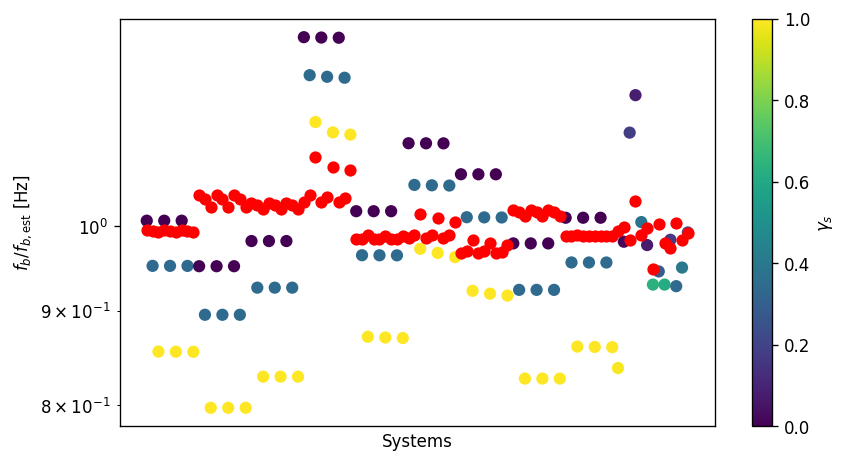

In [86]:
plt.figure(figsize=(8, 4.5), dpi=120)

plt.scatter(
    jnp.arange(len(fits)),
    results["f_b"] / get_f_b_ana(results["m_1"] * MSUN, results["m_2"] * MSUN, results["gamma_s"]) / 1.9e34,
    c=jnp.log10(results["gamma_s"]),
    s=40
)
plt.scatter(
    jnp.arange(len(fits)),
    results["f_b"] / get_f_b(results["m_1"] * MSUN, results["m_2"] * MSUN, results["gamma_s"]),
    c="r",
    s=40
)
plt.colorbar(label=r"$\gamma_s$")
# plt.scatter(
#     jnp.arange(len(fits)),
#     get_f_b(results["m_1"] * MSUN, results["m_2"] * MSUN, results["gamma_s"]),
#     c="r",
#     s=5,
# )

plt.yscale("log")
plt.gca().xaxis.set_ticklabels([])
plt.gca().xaxis.set_ticks([])
plt.xlabel("Systems")
plt.ylabel(r"$f_b / f_{b,\mathrm{est}}$ [Hz]")

Text(0, 0.5, '$f_b$ [Hz]')

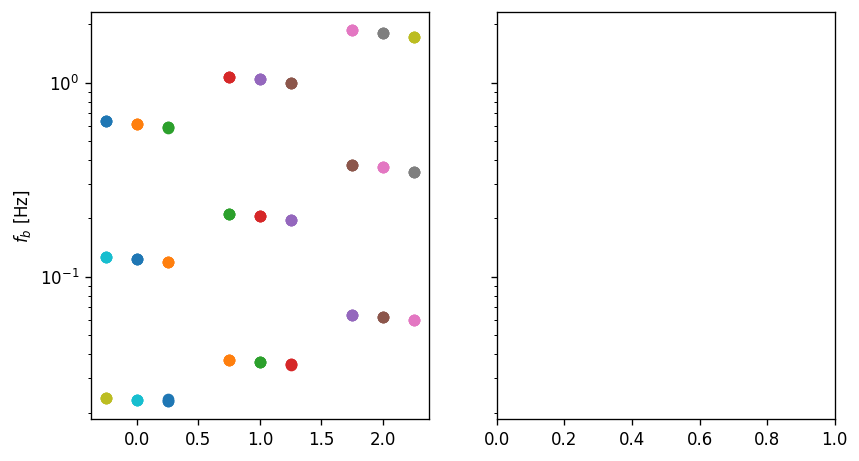

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4.5), dpi=120, sharey=True)

ax = axes[0]

x_coords = np.zeros((9,))
for m_1 in [1000, 3000, 10000]:
    for i, m_2 in enumerate([1, 3, 10]):
        for j, gamma_s in enumerate([2.25, 2.3333, 2.5]):
            idxs = jnp.where(
                (results["m_1"] == m_1)
                & (results["m_2"] == m_2)
                & (results["gamma_s"] == gamma_s)
            )[0]
            ax.scatter(
                len(idxs) * [i + j * 1/4 - 1/4],
                [results["f_b"][i] for i in idxs],
            )

# plt.scatter(results["m_1"], results["f_b"], c=jnp.log10(results["m_2"]), s=40)
# plt.colorbar(label=r"$m_2$ [M$_\odot$]")
# plt.scatter(
#     results["m_1"],
#     get_f_b(results["m_1"] * MSUN, results["m_2"] * MSUN, results["gamma_s"]),
#     c="r",
#     s=5,
#     label="Empirical"
# )
# plt.scatter(
#     results["m_1"],
#     get_f_b_ana(results["m_1"] * MSUN, results["m_2"] * MSUN, results["gamma_s"]) * 1.9e34,
#     c="c",
#     s=5,
#     label="Analytic"
# )

# plt.xscale("log")
ax.set_yscale("log")
# plt.xlabel(r"$m_1$ [M$_\odot$]")
ax.set_ylabel(r"$f_b$ [Hz]")